[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/LightGBMLSS/blob/master/examples/simulation_example_StudentT.ipynb)

# Imports

In [1]:
from lightgbmlss.model import *
from lightgbmlss.distributions.StudentT  import *
from lightgbmlss.datasets.data_loader import load_simulated_studentT_data
from scipy.stats import norm

import matplotlib.pyplot as plt
import plotnine
from plotnine import *
plotnine.options.figure_size = (20, 10)

# Data

In [2]:
train, test = load_simulated_studentT_data()

X_train, y_train = train.filter(regex="x"), train["y"].values
X_test, y_test = test.filter(regex="x"), test["y"].values

dtrain = lgb.Dataset(X_train, label=y_train)

# Distribution Selection

In [3]:
# Specifies Student-T distribution with exp response function and option to stabilize Gradient/Hessian. See ?StudentT for an overview.
lgblss = LightGBMLSS(
    StudentT(stabilization="None",     # Options are "None", "MAD", "L2".
             response_fn="softplus",   # Function to transform the scale-parameter, e.g., "exp" or "softplus".
             loss_fn="nll"             # Loss function. Options are "nll" (negative log-likelihood) or "crps"(continuous ranked probability score).
            )
)

# Hyper-Parameter Optimization

In [4]:
# Any LightGBM hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    # Float/Int sample_type
        # {"param_name": ["sample_type", low, high, log]}
            # sample_type: str, Type of sampling, e.g., "float" or "int"
            # low: int, Lower endpoint of the range of suggested values
            # high: int, Upper endpoint of the range of suggested values
            # log: bool, Flag to sample the value from the log domain or not
    # Example: {"eta": "float", low=1e-5, high=1, log=True]}

    # Categorical sample_type
        # {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            # sample_type: str, Type of sampling, either "categorical"
            # choice1, choice2, choice3, ...: str, Possible choices for the parameter
        # Example: {"boosting": ["categorical", ["gbdt", "dart"]]}

    # For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        # {"param_name": ["none", [value]]},
        # param_name: str, Name of the parameter
        # value: int, Value of the parameter
    # Example: {"gpu_id": ["none", [0]]}

param_dict = {
    "eta":                      ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":                ["int",   {"low": 1,      "high": 10,    "log": False}],
    "num_leaves":               ["int",   {"low": 255,    "high": 255,   "log": False}],  # set to constant for this example
    "min_data_in_leaf":         ["int",   {"low": 20,     "high": 20,    "log": False}],  # set to constant for this example
    "min_gain_to_split":        ["float", {"low": 1e-8,   "high": 40,    "log": False}],
    "subsample":                ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "feature_fraction":         ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "boosting":                 ["categorical", ["gbdt"]],
}

np.random.seed(123)
opt_param = lgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=10,             # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=20,                # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                             )

[I 2023-06-28 14:11:06,246] A new study created in memory with name: LightGBMLSS Hyper-Parameter Optimization
C:\Users\maerzale\.virtualenvs\LightGBMLSS--u9b4l4T\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-06-28 14:11:14,627] Trial 0 finished with value: 3375.322063890989 and parameters: {'eta': 8.198415208623314e-05, 'max_depth': 3, 'num_leaves': 255, 'min_data_in_leaf': 20, 'min_gain_to_split': 16.832485357212377, 'subsample': 0.30355693096926983, 'feature_fraction': 0.6028064750081643, 'boosting': 'gbdt'}. Best is trial 0 with value: 3375.322063890989.
[I 2023-06-28 14:11:22,437] Trial 1 finished with value: 3189.1016098047726 and parameters: {'eta': 0.007073671911916801, 'max_depth': 7, 'num_leaves': 255, 'min_data_in_leaf': 20, 'min_gain_to_split': 38.611479580644264, 'subsample': 0.2506216629843505, 'feature_fraction': 0.36142215340841155, 'boosting': 'gbdt'}. Best is trial 1 with value: 3189.1016098047726.
[I 2023-06-28 14:11:31,342] Trial 2 finished with value: 3331.627086092725 and parameters: {'eta': 0.001009141593001933, 'max_depth': 8, 'num_leaves': 255, 'min_data_in_leaf': 20, 'min_gain_to_split': 22.643537555323384, 'subsample': 0.5664962448060004, 'feature_fraction

# Model Training

In [5]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
lgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

# Prediction

In [42]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
quant_sel = [0.05, 0.95] # Quantiles to calculate from predicted distribution

# Sample from predicted distribution
pred_samples = lgblss.predict(X_test,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = lgblss.predict(X_test,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = lgblss.predict(X_test,
                             pred_type="parameters")

In [7]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,1.569232,4.665352,1.400393,1.832921,1.988856,1.042218,-3.373016,-0.002816,2.254869,3.486455,...,-0.584650,1.220113,0.000378,-0.290512,1.078910,1.156888,1.045662,2.070614,0.048895,0.678586
1,0.774624,-4.569232,-0.491145,1.163867,0.741961,3.553774,5.015033,0.658099,2.513165,0.570279,...,2.834432,1.433060,-0.620396,-0.471309,-3.549989,0.565405,4.201900,-1.194175,7.421316,1.344428
2,1.609959,2.200214,2.032844,2.613764,2.000429,3.258974,2.607335,1.103300,2.226198,2.163984,...,2.583985,4.145258,1.281827,2.168859,1.475804,-0.702351,2.661774,2.889256,0.744218,4.032014
3,-0.230716,0.874905,3.781894,0.806207,0.360069,3.825759,1.881525,-3.138815,0.806561,0.192344,...,4.854953,1.765439,2.438862,-3.352726,0.289171,1.490441,2.936424,-0.533283,0.211834,0.655624
4,3.206626,-0.650994,1.877845,2.460135,0.363719,1.838833,3.283374,1.860133,2.460840,1.282986,...,1.586169,4.989601,4.046617,5.043008,3.211666,2.932719,1.751894,2.096312,1.200453,-0.930477


In [8]:
pred_quantiles.head()

,quant_0.05,quant_0.95
0,-0.573415,2.729852
1,-1.751795,4.278888
2,-0.249624,4.315723
3,-2.124085,4.283253
4,0.626138,5.200949


In [9]:
pred_params.head()

,df,loc,scale,var,std
0,6.776875,1.073504,0.859883,1.048973,1.024194
1,5.998180,1.073504,1.649760,4.083179,2.020688
2,6.415184,1.916509,1.181094,2.026887,1.423688
3,5.998180,1.073504,1.649760,4.083179,2.020688
4,6.776875,2.861794,1.242218,2.189177,1.479587


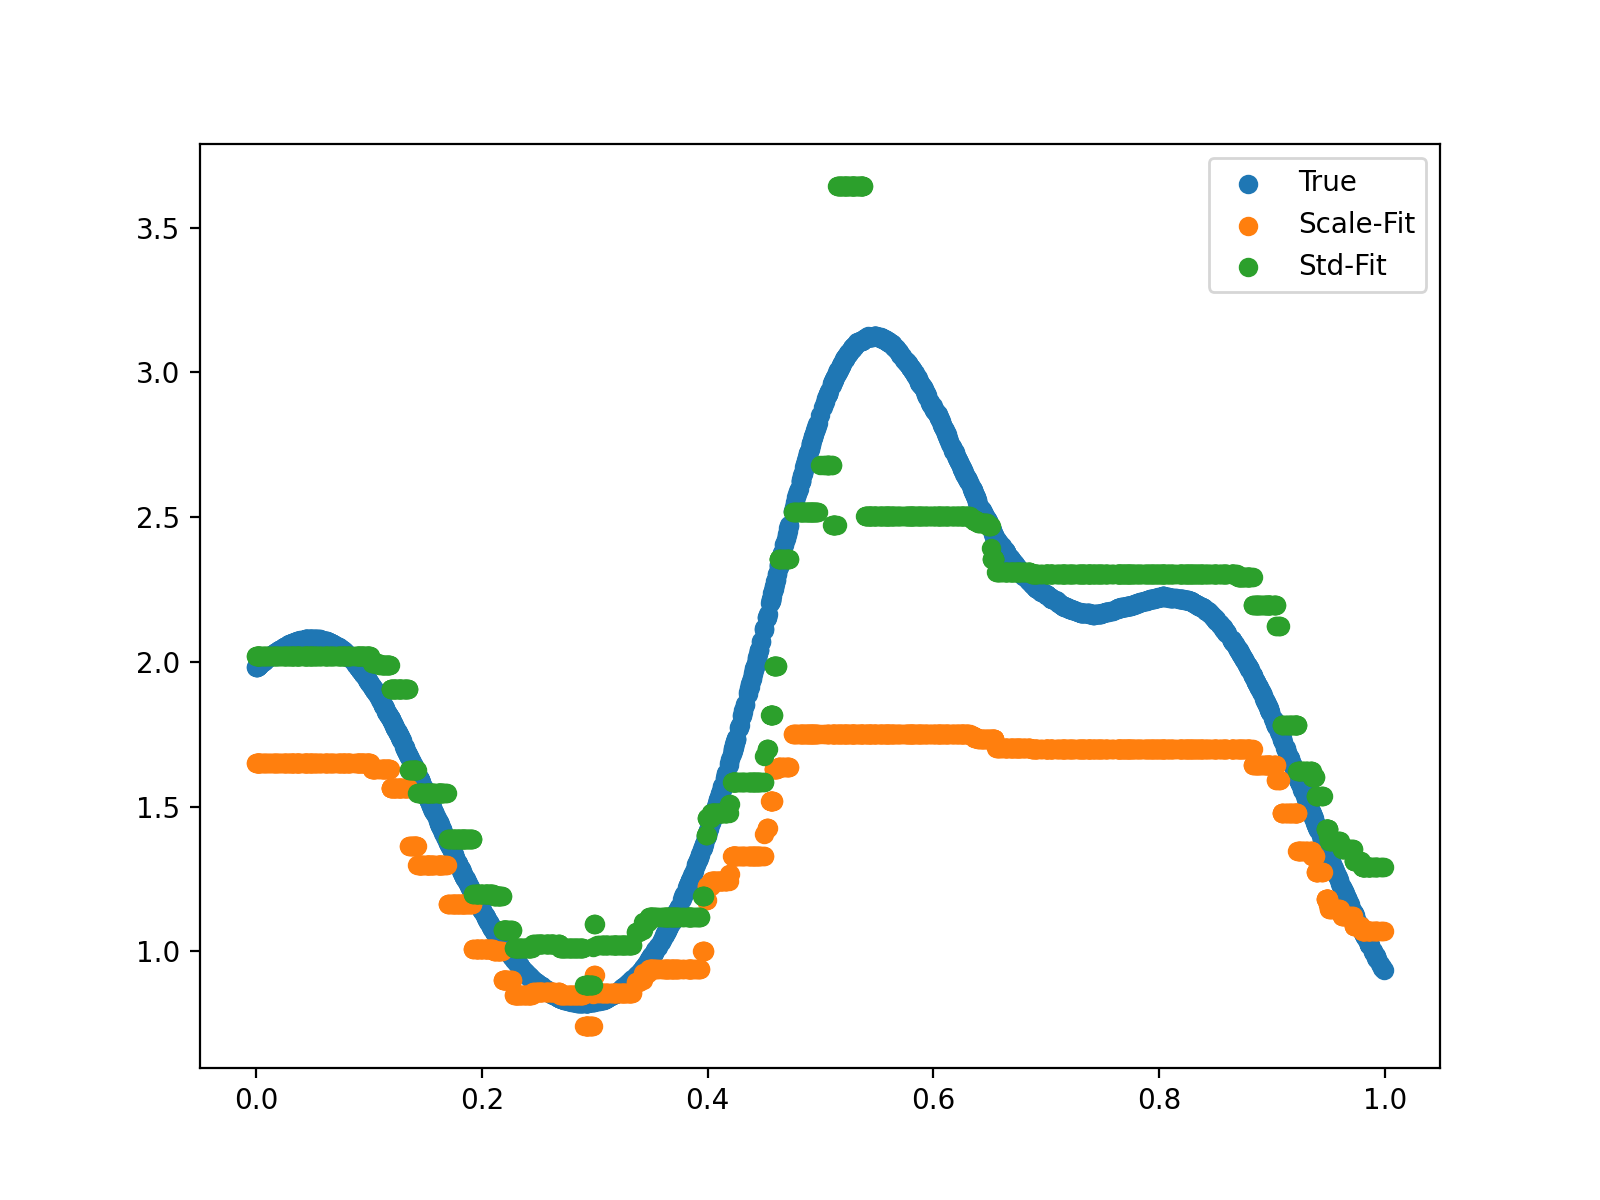

In [53]:
# Note that the variance for the Student-T distribution is defined as df/(df-2) * scale**2. Hence, we need to transform the predicted scale parameter to arrive at the variance.
pred_params["var"] = (pred_params["df"]/(pred_params["df"]-2)) * pred_params["scale"]**2
pred_params["std"] = np.sqrt(pred_params["var"].values)
pred_params["x"] = test.x.values

plt.figure(figsize=(8,6))
plt.scatter("x", "scale", data=test, label="True")
plt.scatter("x", "scale", data=pred_params, label="Scale-Fit")
plt.scatter("x", "std", data=pred_params, label="Std-Fit")
plt.legend(loc=1)
plt.show()

# SHAP Interpretability

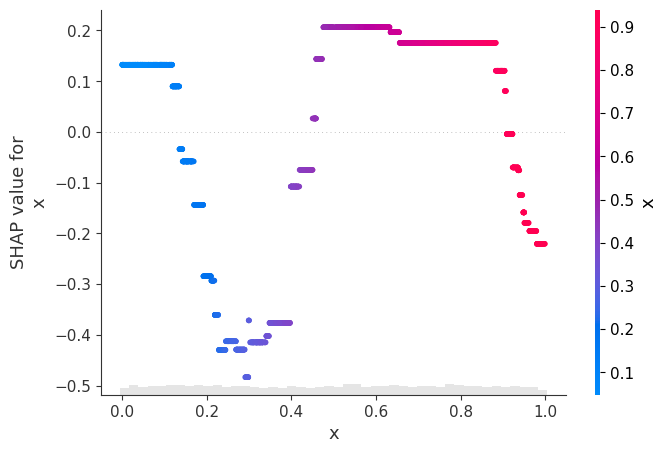

In [10]:
# Partial Dependence Plot of how x acts on scale parameter
lgblss.plot(X_test,
            parameter="scale",
            feature="x",
            plot_type="Partial_Dependence")

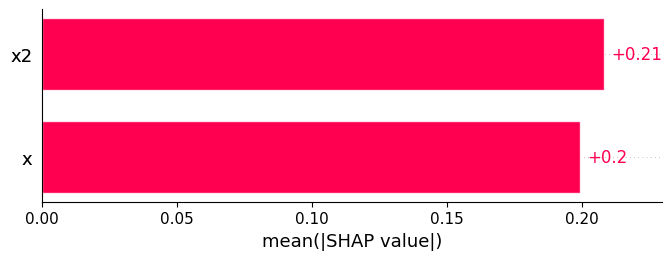

In [11]:
# Feature Importance of scale parameter
lgblss.plot(X_test,
            parameter="scale",
            plot_type="Feature_Importance")